# [AI Innovation Square 릴레이 온라인 특강: 시각] 


## 10.Semantic Segmentation 
 
 - segmentation:  정확한 객체를 픽셀 단위로 추출
     - Semantic Segmentation
         - 클래스별로 구분
     - Instance Segmentation
         - 각 클래스의 객체도 구분
- 각 픽셀단위로 예측,합쳐서 영역이 되는데 경우 비효율적
- 컨본루션으로 축소된 이미지는 의미없어서 deconvolution으로 원본 크기로 복원
    - 위치적 특성을 갖음
- 픽셀단위 예측해서 복원해야 해서 어려움

### 1.모델 구축
Image segmentation with a U-Net-like architecture 모델 구축 참고: https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [30]:
import tensorflow as tf

In [36]:
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   269  100   269    0     0   5380      0 --:--:-- --:--:-- --:--:--  5380
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   274  100   274    0     0  10960      0 --:--:-- --:--:-- --:--:-- 10960
tar: This does not look like a tar archive

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
tar: This does not look like a tar archive

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


함수형 패러다임
- comprehension : 한번에 여러값 생성,변경

In [ ]:
[x for x in range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

PIL로 바로 처리

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

-tf.keras.preprocessing.image : PIL기반이므로 

In [2]:
import tensorflow as tf 
x=tf.keras.preprocessing.image.load_img('1.jpeg')
type(x )#PIL 기반

PIL.JpegImagePlugin.JpegImageFile

In [3]:
from PIL import Image
y=Image.open('1.jpeg')
type(y)

PIL.JpegImagePlugin.JpegImageFile

클래스 상속

In [ ]:
tf.keras.preprocessing.sequence 

- 데이터 파이프라인 구성
- 데이터가 크면 데이터를 하나씩 뽑는 경우가 별로 없음
- Sequence: indexing, slicing 기능 제공해서 추출 가능
    - Pandas DataFrame으로 관리하면 더 편리, ImageDataGenerator 연결

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence): #indexing, slicing
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        #슬라이싱, 인뎅싱으로 관리 용이
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [ ]:
tf.keras.utils.Sequence

In [ ]:
class X:
    pass
x=X()
x[0] #인덱싱,슬라이싱 불가

TypeError: 'X' object is not subscriptable

In [ ]:
class X:
    def __getitem__(self,x):
        return 0
x=X()
x[0] #__getitem__ 정의되어 인덱싱,슬라이싱 

0

### U-Net Xception-style 모델
- 함수형 패러다임 이용
    - Model multi-inputs,multi-outputs 가능
- 데이터가 적은 경우  경량화 모델, 전이학습 
- 경량화 모델 Xception
    - SeparableConv2D: Convolution연산 경량화(depth-wise,point-wise,Separable)
    - 성능과 속도의 trade-off
    - 학습 통한 복원 Conv2DTranspose

- FCN(Fully convolution network) 컨볼루션만으로 이루어져서 Dense레이어 없음
- shape 맞출 필요 없음


In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # 함수형 패러다임
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  #이전에 값을 받아옴

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  #2개 입력 동시에 받음
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###
   #복원 Conv2DTranspose
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


#메모리 지우는 용도로 이전에 저장된 모델 지움
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

In [ ]:
from operator import add #함수형 패러다임
add(3,4)

7

In [ ]:
tf.keras.layers.Add()([1,2]) #객체
tf.keras.layers.add([1,2])   #함수

<tf.Tensor: shape=(), dtype=int32, numpy=3>

- grid search CV: brute force 방식
- keras Tuner:  하이퍼 파라미터 튜닝에 사용, 최적의 네트워크 찾아줌
- AutoKeras 간단하게 최적의 구조 만들어줌
- tpot: 유전자 알고리즘 이용 최적의 모델 찾음

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

학습
- callbacks technique

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

예측 시각화

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


---
### 2.Transfer Learning

AD-HOC 서로 다른 솔루션 제시
- 검증된 모델 가져다가 씀

segmenatation Transfer Learning 참고 : 
https://www.tensorflow.org/tutorials/images/segmentation?hl=ko

In [14]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-cd5_x5su
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-cd5_x5su
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0964dc3b7ae48033fd477a82be3c1572735e26f5_-cp36-none-any.whl size=188737 sha256=cb8423cdb26b8596a59caed636810740313dc3bc8118810bf068c322cf9a885b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rdrwkupn/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.6/dist-packages (4.1.0.dev202012290107)


In [10]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [11]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


- cast :계산을 위해서 tf.float32로 변경
- [0.1] 정규화

In [12]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

data augmentation
- 좌우반전

@tf.function
- JIT : 적은 연산일때 향상 큼

- TensorBoard Profiling 시각화하여 학습시 epoch마다 병목현상 체크

In [13]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

학습시 epoch마다 시간체크해서 병목현상 체크

In [15]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [17]:
#TF 자동 튜닝해서 성능 최적화
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
#메모리 미리 올림
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [18]:
def display(display_list):
    ''' 이미지 시각화'''
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

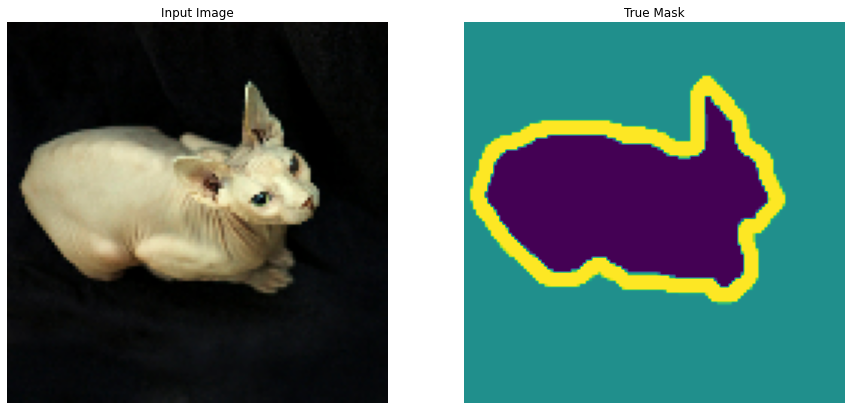

In [19]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

- Pix2pix GAN모델 가져옴

- 특징 추출기 MobileNetV2 경량화 모델을 fully connected layer없이 가져옴


In [20]:
OUTPUT_CHANNELS = 3
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
#학습시키지 않음
down_stack.trainable = False 

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
#U-net모델 : encoder - decoder
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 모델을 통해 다운샘플링합시다
  skips = down_stack(x)
  x = skips[-1]   #마지막
  skips = reversed(skips[:-1]) #차례 변경

  # 건너뛰기 연결을 업샘플링하고 설정하세요
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate() #클래스로 재사용
    x = concat([x, skip])
#tf.keras.layers.Concatenate()([x, skip])
  # 이 모델의 마지막 층입니다
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

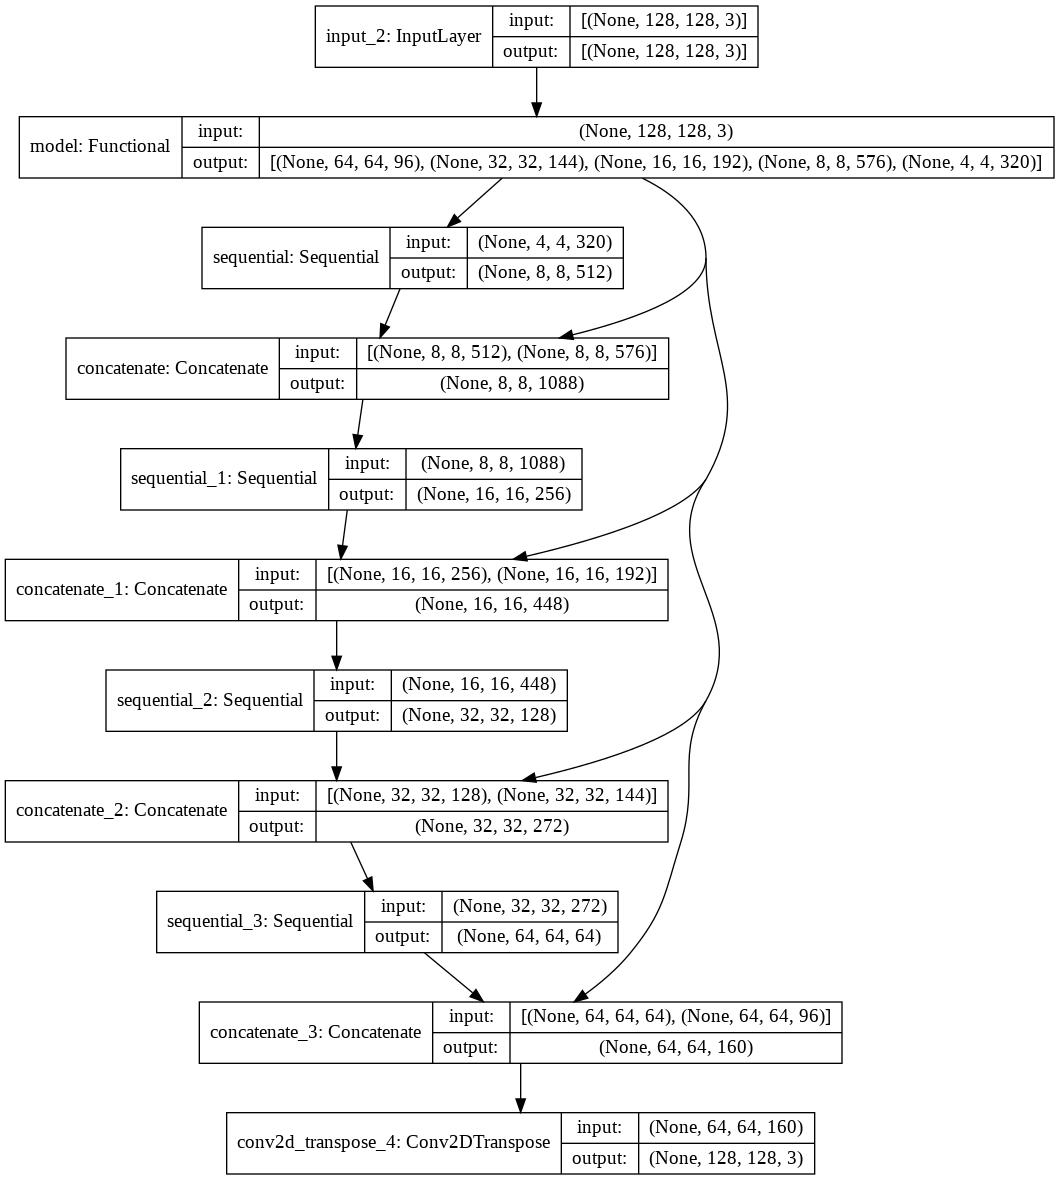

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
def create_mask(pred_mask): #마스크 그리기
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

- 성능이 별로임
- 흑백데이터가 유리함

- 학습이 어떻게 변하는지 20번의 에포크 끝날때마다 이미지 시각화하여 Callback이용해서 체크

In [27]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

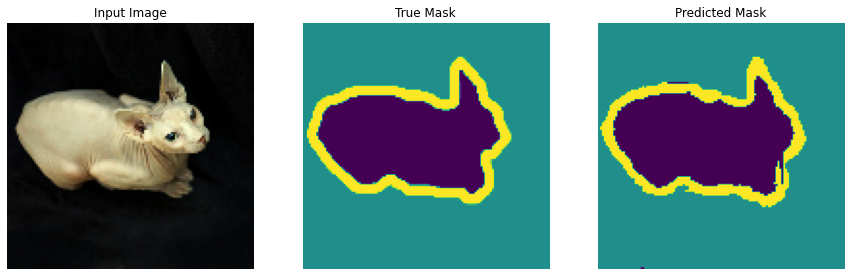


에포크 이후 예측 예시 20



In [28]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

수치로 확인 불가한 결과 테스트 
- 기존의 metrics로는 불가
- indexing, slicing 되는 경우 1개씩 테스트해서 어떠한 이미지에 잘되고 안되는지 확인
- tf.data next(iter()) ,for... break

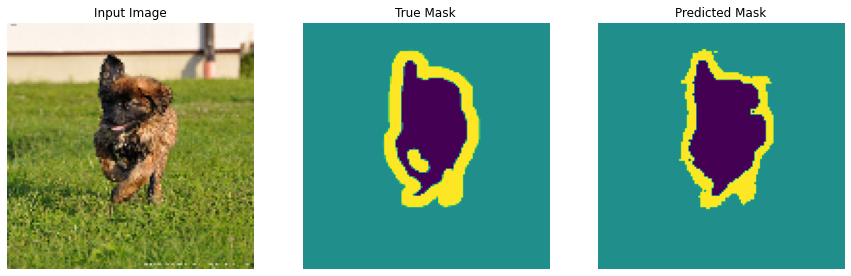

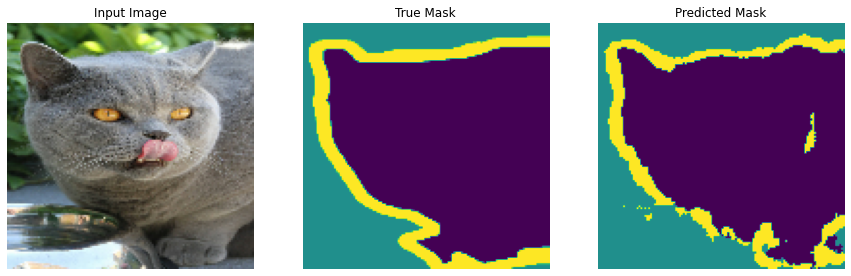

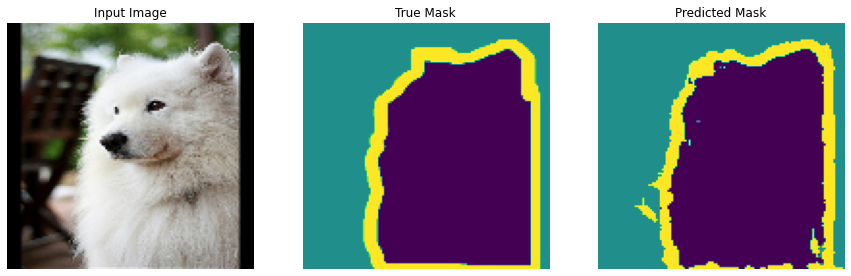

In [29]:
show_predictions(test_dataset, 3)

### style transfer
- gram matrix
    - tf.linalg.einsum (아인슈타인 summation): 벡터 연산 간단하게 해서 논문 구현시 유용
- loss 복잡하면  tf.GradientTape 이용
- 참고: https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))